In [1]:
# ! git clone https://github.com/ClaudioPaterniti/MinesweeperLearning.git

In [2]:
# ! pip install plotly-express

In [3]:
import os
os.chdir('/content/MinesweeperLearning')

In [4]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from src.model import MineSweeperDataset, PatchMLPModel, OnHotEncodingTransform, Game
from src.player import ThresholdPlayer

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cuda


In [6]:
train = Game(16, 30, 99, n = 10000)
train.random_open(0.3)
train.random_flags(0.3)
test = Game(n = 100)
test.random_open(0.3)
test.random_flags(0.3)

In [7]:
patch_radius = 3
name = f'patch_mlp_7x7_256_halving'
transform = OnHotEncodingTransform(patch_radius)
training_data = MineSweeperDataset(train, transform, losing_moves_weight=10)
test_data = MineSweeperDataset(test, transform)
train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)
model = PatchMLPModel(patch_radius, layers=[2**i for i in range(8, 0, -1)], device=device)
player = ThresholdPlayer(model, 0.05, 0.95)
optimizer = torch.optim.Adam(model.model.parameters(), lr=0.001)

In [8]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train(train_dataloader, optimizer)
    model.test(test_dataloader)

Epoch 1
-------------------------------
Epoch 2
-------------------------------
Epoch 3
-------------------------------
Epoch 4
-------------------------------
Epoch 5
-------------------------------


In [ ]:
reinforcing_iterations = 10
epochs = 2
for i in range(reinforcing_iterations):
    games = Game(16, 30, 99, n = 1000)
    games.random_open(0.3)
    player.play(games)
    training_data.mix(games)
    train_dataloader = DataLoader(training_data, batch_size=64)
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        model.train(train_dataloader, optimizer)
        model.test(test_dataloader)

step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
Epoch 1
-------------------------------
Epoch 2
-------------------------------
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
step 34
step 35
step 36
step 37
step 38
step 39
step 40
step 41
step 42
step 43
step 44
step 45
step 46
step 47
step 48
step 49
step 50
step 51
step 52
step 53
step 54
step 55
step 56
step 57
step 58
step 59
step 60
step 61
Epoch 1
-------------------------------
Epoch 2
-------------------------------
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
ste

In [10]:
model.save(os.path.join('weights', name + '.pth'))

In [11]:
import plotly_express as px
import pandas as pd
df = pd.DataFrame({'train': model.train_loss_log, 'test': model.test_loss_log})
px.line(df)

In [12]:
g = np.array([[
    [9,9,9,9,9,9,9,9,9],
    [9,10,4,2,2,9,9,1,9],
    [10,10,2,1,10,2,1,2,9],
    [2,2,1,2,2,2,0,2,9],
    [0,1,1,2,10,1,1,3,9],
    [0,1,10,2,1,2,3,10,9],
    [0,1,1,1,0,1,10,10,9],
]])

In [13]:
from src.utils import pyplot_game

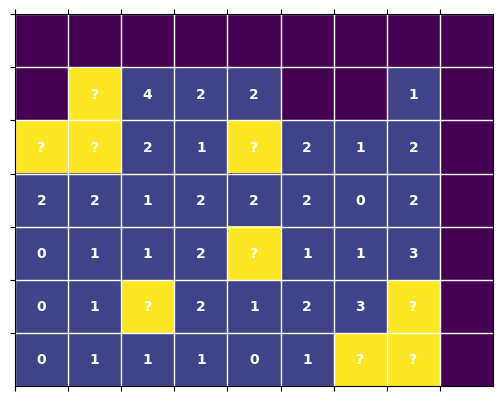

<Axes: >

In [14]:
pyplot_game(g[0])

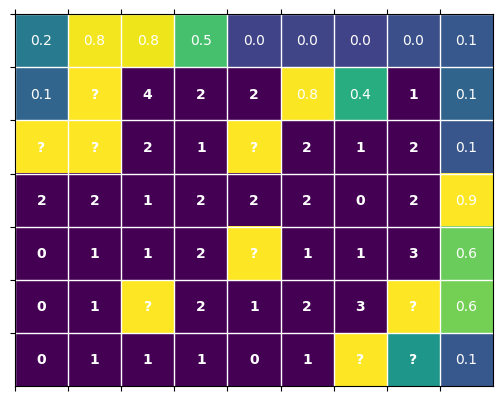

<Axes: >

In [15]:
p = model(g)
pyplot_game(g[0], mine_probs=p[0])

In [16]:
g = Game(16, 30, 99, n=1)
g.random_open(0.3)
g.random_flags(0.3)

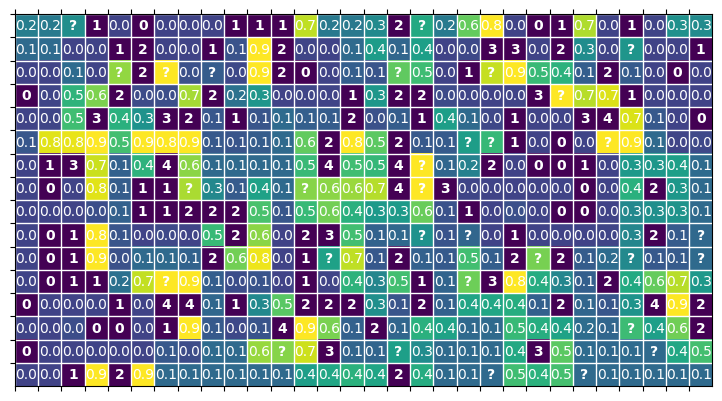

<Axes: >

In [17]:
p = model(g.game_state())
g.pyplot_game(0, mine_probs=p[0], hightlight_losing_only=True)

[False]
[False]


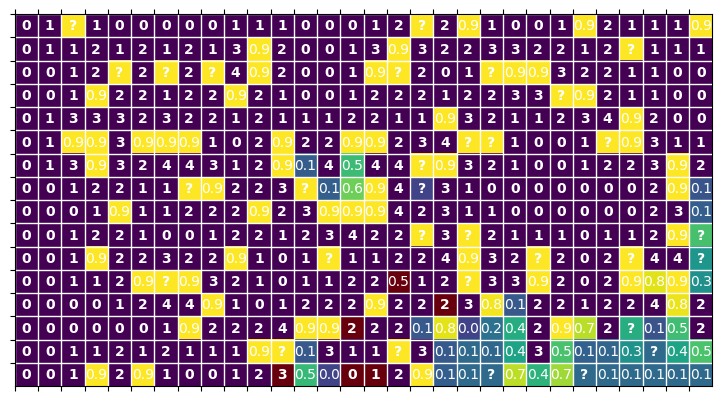

<Axes: >

In [26]:
p, o, f = player.step(g)
print(g.active_games)
print(g.won)
p = model(g.game_state())
g.pyplot_game(0, mine_probs=p[0], hightlight_losing_only=False)

In [20]:
model.model.conv_in.weight[1, 2]

tensor([[ 0.0125, -0.0429, -0.0059, -0.0546,  0.0430, -0.0185,  0.0592],
        [-0.0207, -0.0351, -0.0492,  0.0106,  0.0164,  0.1011,  0.0151],
        [-0.0198, -0.0865,  0.0287, -0.0136, -0.0391,  0.0251, -0.0361],
        [-0.0234,  0.0089,  0.0145, -0.0000, -0.2327,  0.0877, -0.0234],
        [-0.0013,  0.0004,  0.0847,  0.0115, -0.0881, -0.0174, -0.0049],
        [-0.0534,  0.0135, -0.0026,  0.0219, -0.0392, -0.0521,  0.0320],
        [ 0.0348,  0.0399, -0.0566, -0.0541, -0.0223, -0.0589,  0.0201]],
       device='cuda:0', grad_fn=<SelectBackward0>)